# Transport Model Classification using a Bidirectional LSTM

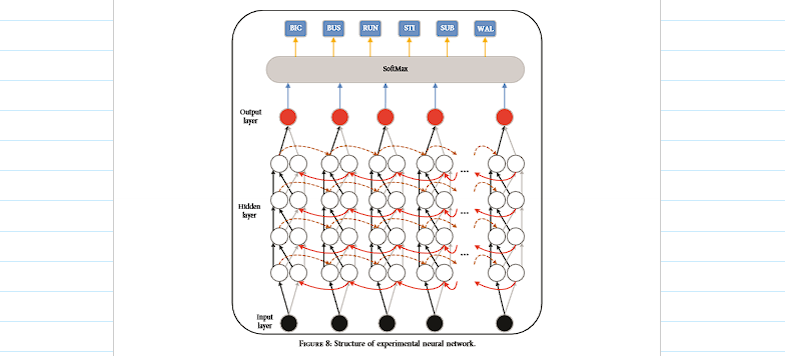

In [1]:
import numpy as np
import pandas as pd
import torch

In [2]:
X = np.load('./data/lstm_features_labels/lstm_features.npy')
X = torch.tensor(X, dtype=torch.float32)
y = np.load('./data/lstm_features_labels/lstm_labels.npy')
y = torch.tensor(y, dtype=torch.float32)
print(y.unique())

tensor([1., 2., 3., 4., 5., 6., 7., 8.])


Instead of multiclass classification, binary classification is better since it fits into the problem at hand. I'm only concerned with when the data is taken in the car and not anywhere else.

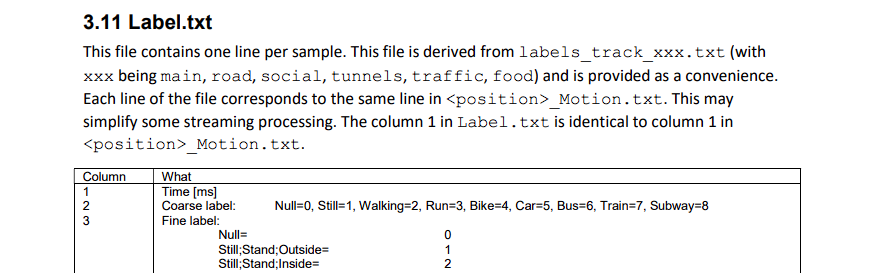

In [ ]:
# Choose "car" as the positive class while the rest as negative
y_mapped = torch.where(y == 5, torch.tensor(1.), torch.tensor(0.))

In [3]:
# # Adjust labels to start from 0
# y = y - 1

# Convert to long tensor
y = y.long()

print(y.unique())

tensor([0, 1, 2, 3, 4, 5, 6, 7])


In [4]:
X.shape, y.shape

(torch.Size([588, 128, 6]), torch.Size([588]))

In [5]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold, train_test_split

In [6]:
class TransportModeDataset(Dataset):
      def __init__(self, features, labels):
            self.features = features
            self.labels = labels

      def __len__(self):
            return len(self.features)

      def __getitem__(self, idx):
            return self.features[idx], self.labels[idx]


In [7]:
def create_dataloaders(features, labels, k=5, batch_size=16):
      
      kf = KFold(n_splits=k, shuffle=True, random_state=42)
      dataloaders = []

      for train_index, val_index in kf.split(features):
            train_features, val_features = features[train_index], features[val_index]
            train_labels, val_labels = labels[train_index], labels[val_index]

            train_dataset = TransportModeDataset(train_features, train_labels)
            validation_dataset = TransportModeDataset(val_features, val_labels)

            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

            dataloaders.append((train_loader, validation_loader))
      
      return dataloaders

In [8]:
# Split data into train/val/test
train_val_idx, test_idx = train_test_split(np.arange(len(y)), test_size=0.2, random_state=42, stratify=y)

train_val_data = (X[train_val_idx], y[train_val_idx])

test_data = TransportModeDataset(X[test_idx], y[test_idx])

In [9]:
# Prepare test DataLoader
batch_size = 16
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

In [11]:
class BiLSTMNetwork(nn.Module):
      def __init__(self, input_size, hidden_size, num_layers):
            super(BiLSTMNetwork, self).__init__()
            self.hidden_size = hidden_size
            self.num_layers = num_layers
            # Bi-LSTM layers
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
            # Fully connected layer
            self.fc = nn.Linear(hidden_size * 2, 1)  # *2 for bidirection
            self.relu = nn.ReLU()

      def forward(self, x):
            # Initialize hidden state with zeros
            h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device) # *2 for bidirectional
            c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
            
            # LSTM forward pass
            out, _ = self.lstm(x, (h0, c0))
            out = self.relu(out)
            # Decode the hidden state of the last time step
            out = self.fc(out[:, -1, :])
            return out

In [26]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

def train_validation(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs, device, save_path=None):
      train_losses = []
      val_losses = []
      train_accuracies = []
      val_accuracies = []

      for epoch in range(epochs):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            for features, labels in train_loader:
                  features, labels = features.to(device), labels.to(device)

                  optimizer.zero_grad()
                  outputs = model(features)
                  loss = criterion(outputs, labels)
                  loss.backward()
                  optimizer.step()

                  running_loss += loss.item()
                  _, predicted = torch.max(outputs.data, 1)
                  total += labels.size(0)
                  correct += (predicted == labels).sum().item()

            train_loss = running_loss / len(train_loader)
            train_accuracy = 100 * correct / total
            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)

            model.eval()
            val_loss = 0.0
            correct = 0
            total = 0

            with torch.no_grad():
                  for features, labels in val_loader:
                        features, labels = features.to(device), labels.to(device)
                        outputs = model(features)
                        loss = criterion(outputs, labels)
                        val_loss += loss.item()
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()

            val_loss /= len(val_loader)
            val_accuracy = 100 * correct / total
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)

            scheduler.step()

            print(f'   Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
            
            # Save checkpoint
            if save_path:
                  torch.save({
                  'epoch': epoch,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'loss': loss,
                  }, save_path)

      return train_losses, val_losses, train_accuracies, val_accuracies

def test(model, test_loader, criterion, device):
      model.eval()
      test_loss = 0.0
      correct = 0
      total = 0

      with torch.no_grad():
            for features, labels in test_loader:
                  features, labels = features.to(device), labels.to(device)
                  outputs = model(features)
                  loss = criterion(outputs, labels)
                  test_loss += loss.item()
                  _, predicted = torch.max(outputs.data, 1)
                  total += labels.size(0)
                  correct += (predicted == labels).sum().item()

      test_loss /= len(test_loader)
      test_accuracy = 100 * correct / total

      print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
      return test_loss, test_accuracy


In [27]:
train_val_idx, test_idx = train_test_split(np.arange(len(y)), test_size=0.2, random_state=42, stratify=y)
train_val_data = (X[train_val_idx], y[train_val_idx])
test_data = TransportModeDataset(X[test_idx], y[test_idx])
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

In [30]:
# Generate k-fold DataLoaders for training and validation
k = 5
batch_size = 4
dataloaders = create_dataloaders(train_val_data[0], train_val_data[1], k, batch_size)

# Hyperparameters
input_size = 6
hidden_size = 64
num_layers = 2
output_size = 8
learning_rate_base = 0.01
learning_rate_decay = 0.95
epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [31]:
# arr for storing hist
loss_hist = []
acc_hist = []


# Training and validation
for fold, (train_loader, val_loader) in enumerate(dataloaders):
      print(f"Fold {fold + 1}")

      model = BiLSTMNetwork(input_size, hidden_size, num_layers, output_size).to(device)
      criterion = nn.CrossEntropyLoss()
      optimizer = optim.Adam(model.parameters(), lr=learning_rate_base)
      scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: learning_rate_base * (learning_rate_decay ** epoch))

      save_path = f'./model_checkpoint/BiLSTM_model_fold_{fold + 1}.pth'
      train_losses, val_losses, train_accuracies, val_accuracies = train_validation(
            model, train_loader, val_loader, criterion, optimizer, scheduler, epochs, device, save_path
      )

      loss_hist.append([train_losses, val_losses])
      acc_hist.append([train_accuracies, val_accuracies])
      # Save losses and accuracies
      #np.save(f'train_losses_fold_{fold + 1}.npy', np.array(train_losses))
      #np.save(f'val_losses_fold_{fold + 1}.npy', np.array(val_losses))
      #np.save(f'train_accuracies_fold_{fold + 1}.npy', np.array(train_accuracies))
      #np.save(f'val_accuracies_fold_{fold + 1}.npy', np.array(val_accuracies))

Fold 1
   Epoch [1/10], Train Loss: 2.0645, Train Accuracy: 12.77%, Val Loss: 2.0411, Val Accuracy: 22.34%
   Epoch [2/10], Train Loss: 2.0157, Train Accuracy: 30.59%, Val Loss: 2.0022, Val Accuracy: 31.91%
   Epoch [3/10], Train Loss: 1.9555, Train Accuracy: 35.11%, Val Loss: 1.9576, Val Accuracy: 34.04%
   Epoch [4/10], Train Loss: 1.8887, Train Accuracy: 35.64%, Val Loss: 1.9192, Val Accuracy: 34.04%
   Epoch [5/10], Train Loss: 1.8320, Train Accuracy: 35.37%, Val Loss: 1.8942, Val Accuracy: 37.23%
   Epoch [6/10], Train Loss: 1.7902, Train Accuracy: 36.17%, Val Loss: 1.8734, Val Accuracy: 37.23%
   Epoch [7/10], Train Loss: 1.7587, Train Accuracy: 37.50%, Val Loss: 1.8521, Val Accuracy: 37.23%
   Epoch [8/10], Train Loss: 1.7332, Train Accuracy: 37.23%, Val Loss: 1.8295, Val Accuracy: 37.23%
   Epoch [9/10], Train Loss: 1.7096, Train Accuracy: 38.56%, Val Loss: 1.8120, Val Accuracy: 37.23%
   Epoch [10/10], Train Loss: 1.6877, Train Accuracy: 38.30%, Val Loss: 1.7980, Val Accuracy: